# Flood Exposure Notebook

**Explore S2S Metadata and API**

This notebook walks through an example that explores the Space2Stats Metadata, and then uses the API to fetch flood data for various provinces within a country.

In [1]:
import pandas as pd
import geopandas as gpd
from shapely import from_geojson
import matplotlib.pyplot as plt # pip install matplotlib contextily
import contextily as ctx
from space2stats_client import Space2StatsClient

# Initialize the client
client = Space2StatsClient()

## Query Metadata

Each dataset in Space2Stats is stored as a STAC item. Metadata for each item can be explored through the following [browser](https://radiantearth.github.io/stac-browser/#/external/raw.githubusercontent.com/worldbank/DECAT_Space2Stats/refs/heads/main/space2stats_api/src/space2stats_ingest/METADATA/stac/space2stats-collection/collection.json). 

The `get_topics` function retrieves a list of dictionaries with key details for each dataset. The keys in each dictionary are the item ids.

In [2]:
topics = client.get_topics()
pd.options.display.max_colwidth = None
topics

Item ID,name,description,source_data
space2stats_population_2020,Population,Gridded population disaggregated by gender.,"WorldPop gridded population, 2020, Unconstrained, UN-Adjusted, https://www.worldpop.org/methods/top_down_constrained_vs_unconstrained/"
flood_exposure_15cm_1in100,Population Exposed to Floods,"Population where flood depth is greater than 15 cm, 1-in-100 return period.","Fathom 3.0 High Resolution Global Flood Maps Including Climate Scenarios, https://datacatalog.worldbank.org/search/dataset/0065653/Fathom-3-0---High-Resolution-Global-Flood-Maps-Including-Climate-Scenarios"
urbanization_ghssmod,Urbanization by population and by area,"Urbanization is analyzed using the GHS-SMOD dataset, including comparisons with population",Global Human Settlement Layer (https://human-settlement.emergency.copernicus.eu/degurbaDefinitions.php)
nighttime_lights,Nighttime Lights,Sum of luminosity values measured by monthly composites from VIIRS satellite.,"World Bank - Light Every Night, https://registry.opendata.aws/wb-light-every-night/"


We can extract additional metadata like fields and descriptions using the item id.

In [3]:
properties = client.get_properties("flood_exposure_15cm_1in100")
properties

,name,description,type
0,hex_id,H3 unique identifier,object
1,pop,"Sum of Gridded Population, 2020",float32
2,pop_flood,"Sum of population exposed to floods greater than 15 cm, 1 in 100 return period",float64
3,pop_flood_pct,"Percent of population exposed to floods greater than 15 cm, 1 in 100 return period",float64


Alternatively, we can also explore the fields avaialble via the API fields endpoint:

In [4]:
fields = client.get_fields()
fields

['sum_viirs_ntl_2024',
 'ogc_fid',
 'sum_pop_f_0_2020',
 'sum_pop_f_10_2020',
 'sum_pop_f_15_2020',
 'sum_pop_f_1_2020',
 'sum_pop_f_20_2020',
 'sum_pop_f_25_2020',
 'sum_pop_f_30_2020',
 'sum_pop_f_35_2020',
 'sum_pop_f_40_2020',
 'sum_pop_f_45_2020',
 'sum_pop_f_50_2020',
 'sum_pop_f_55_2020',
 'sum_pop_f_5_2020',
 'sum_pop_f_60_2020',
 'sum_pop_f_65_2020',
 'sum_pop_f_70_2020',
 'sum_pop_f_75_2020',
 'sum_pop_f_80_2020',
 'sum_pop_m_0_2020',
 'sum_pop_m_10_2020',
 'sum_pop_m_15_2020',
 'sum_pop_m_1_2020',
 'sum_pop_m_20_2020',
 'sum_pop_m_25_2020',
 'sum_pop_m_30_2020',
 'sum_pop_m_35_2020',
 'sum_pop_m_40_2020',
 'sum_pop_m_45_2020',
 'sum_pop_m_50_2020',
 'sum_pop_m_55_2020',
 'sum_pop_m_5_2020',
 'sum_pop_m_60_2020',
 'sum_pop_m_65_2020',
 'sum_pop_m_70_2020',
 'sum_pop_m_75_2020',
 'sum_pop_m_80_2020',
 'sum_pop_m_2020',
 'sum_pop_f_2020',
 'sum_pop_2020',
 'pop',
 'pop_flood',
 'pop_flood_pct',
 'ghs_11_count',
 'ghs_12_count',
 'ghs_13_count',
 'ghs_21_count',
 'ghs_22_count',

## Extract H3 Data

Let's work with the subset of fields from the flood exposure item: `['pop', 'pop_flood', 'pop_flood_pct']`

In [5]:
flood_vars = ['pop', 'pop_flood', 'pop_flood_pct']

We will define our AOIs by fetching admin boundaries from the GeoBoundaries project.

<Axes: >

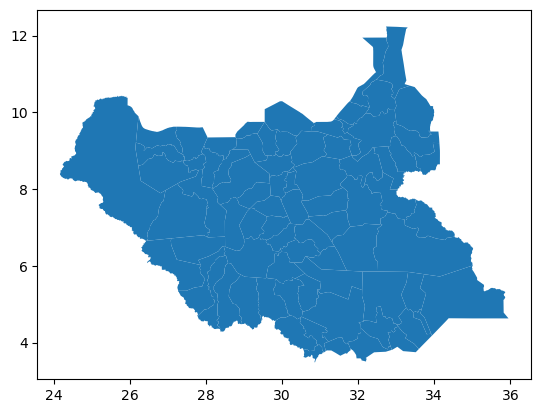

In [6]:
# Try fetching the boundaries
ISO3 = "SSD" # South Sudan
ADM = "ADM2" # Level 2 administrative boundaries
adm_boundaries = client.fetch_admin_boundaries(ISO3, ADM)
adm_boundaries.plot()

In [7]:
client.get_summary?

Signature:
client.get_summary(
    gdf: geopandas.geodataframe.GeoDataFrame,
    spatial_join_method: Literal['touches', 'centroid', 'within'],
    fields: List[str],
    geometry: Optional[Literal['polygon', 'point']] = None,
) -> pandas.core.frame.DataFrame
Docstring:
Extract h3 level data from Space2Stats for a GeoDataFrame.

Parameters
----------
gdf : GeoDataFrame
    The Areas of Interest

spatial_join_method : ["touches", "centroid", "within"]
    The method to use for performing the spatial join between the AOI and H3 cells
        - "touches": Includes H3 cells that touch the AOI
        - "centroid": Includes H3 cells where the centroid falls within the AOI
        - "within": Includes H3 cells entirely within the AOI

fields : List[str]
    A list of field names to retrieve from the statistics table.

geometry : Optional["polygon", "point"]
    Specifies if the H3 geometries should be included in the response.

Returns
-------
DataFrame
    A DataFrame with the requested fie

Run API Calls

In [8]:
df = client.get_summary(
    gdf=adm_boundaries, 
    spatial_join_method="centroid", 
    fields=flood_vars,
    geometry="polygon"
)

In [9]:
pd.reset_option('display.max_colwidth')
df.head()

,shapeName,shapeISO,shapeID,shapeGroup,shapeType,index_gdf,index_h3,hex_id,geometry,pop,pop_flood,pop_flood_pct
0,Morobo,,79223893B16328156709571,SSD,ADM2,0,0,866ae1067ffffff,"{""type"":""Polygon"",""coordinates"":[[[30.62327290...",4204.4385,609.631552,0.144997
1,Morobo,,79223893B16328156709571,SSD,ADM2,0,1,866ae106fffffff,"{""type"":""Polygon"",""coordinates"":[[[30.68007919...",4776.9630,459.478346,0.096186
2,Morobo,,79223893B16328156709571,SSD,ADM2,0,2,866ae114fffffff,"{""type"":""Polygon"",""coordinates"":[[[30.61445415...",3752.4004,341.734756,0.091071
3,Morobo,,79223893B16328156709571,SSD,ADM2,0,3,866ae116fffffff,"{""type"":""Polygon"",""coordinates"":[[[30.60563958...",3304.6606,392.324178,0.118718
4,Morobo,,79223893B16328156709571,SSD,ADM2,0,4,866ae132fffffff,"{""type"":""Polygon"",""coordinates"":[[[30.84166572...",7512.3320,865.229318,0.115175


Check that there are no duplicate hexagon ids

In [10]:
df['hex_id'].duplicated().sum()

0

Convert geometry column from geojson into shapely polygons

In [11]:
df["geometry"] = df["geometry"].apply(lambda geom: from_geojson(geom))
gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")
gdf.head()

,shapeName,shapeISO,shapeID,shapeGroup,shapeType,index_gdf,index_h3,hex_id,geometry,pop,pop_flood,pop_flood_pct
0,Morobo,,79223893B16328156709571,SSD,ADM2,0,0,866ae1067ffffff,"POLYGON ((30.62327 3.62973, 30.63632 3.66096, ...",4204.4385,609.631552,0.144997
1,Morobo,,79223893B16328156709571,SSD,ADM2,0,1,866ae106fffffff,"POLYGON ((30.68008 3.60768, 30.69312 3.63891, ...",4776.9630,459.478346,0.096186
2,Morobo,,79223893B16328156709571,SSD,ADM2,0,2,866ae114fffffff,"POLYGON ((30.61445 3.68759, 30.6275 3.71879, 3...",3752.4004,341.734756,0.091071
3,Morobo,,79223893B16328156709571,SSD,ADM2,0,3,866ae116fffffff,"POLYGON ((30.60564 3.7454, 30.61869 3.77659, 3...",3304.6606,392.324178,0.118718
4,Morobo,,79223893B16328156709571,SSD,ADM2,0,4,866ae132fffffff,"POLYGON ((30.84167 3.59938, 30.85469 3.6306, 3...",7512.3320,865.229318,0.115175


Map hexagon data

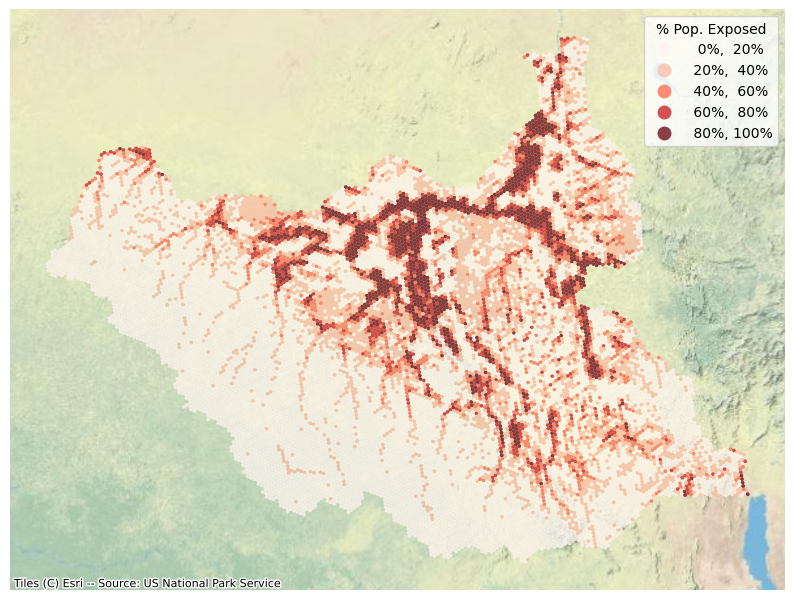

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf.plot(ax=ax, column="pop_flood_pct", 
         legend=True, cmap="Reds", alpha=0.75, 
         scheme="equal_interval", k=5, 
         legend_kwds=dict(title='% Pop. Exposed', fmt="{:.0%}"),
         linewidth=0)
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldPhysical, crs='EPSG:4326')
plt.axis("off")
plt.show()

## Extract Admin Summaries

In [24]:
adm_boundaries_zs = client.get_aggregate(
    gdf=adm_boundaries, 
    spatial_join_method="centroid", 
    fields=['pop', 'pop_flood'], 
    aggregation_type="sum"
)

In [ ]:
adm_boundaries_zs.head()

: 

Recalculate share of population exposed with aggregate data

In [18]:
adm_boundaries_zs.loc[:, "pop_flood_pct"] = adm_boundaries_zs["pop_flood"] / adm_boundaries_zs["pop"]

: 

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
adm_boundaries_zs.plot(
    ax=ax, column="pop_flood_pct", legend=True, 
    cmap="Reds", scheme="natural_breaks", 
    k=5, legend_kwds=dict(title='% Pop. Exposed', fmt="{:.0%}"),
    linewidth=0.2, edgecolor='black')
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldPhysical, crs='EPSG:4326')
plt.axis("off")
plt.show()

: 

List top 20 provinces by population exposed

In [ ]:
table = adm_boundaries_zs.sort_values('pop_flood_pct', ascending=False).head(20)[['shapeName', 'pop_flood', 'pop_flood_pct']].rename(
    columns={
        'shapeName': 'Province'
        })
table.loc[:, "Population Exposed"] = table.loc[:, "pop_flood"].apply(lambda x: f"{x:,.0f}")
table.loc[:, "Population Exposed (%)"] = table.loc[:, "pop_flood_pct"].apply(lambda x: f"{x:.2%}")
table.reset_index(drop=True, inplace=True)
display(table[['Province', 'Population Exposed', 'Population Exposed (%)']])